In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import pandas as pd
import nltk
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


Using TensorFlow backend.


 ## Data Exploration

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
test_labels = pd.read_csv("data/test_labels.csv")



In [3]:
len(train_data), len(test_data)



(159571, 153164)

In [4]:
train_data.head()



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_data["id"].head()



0    0000997932d777bf
1    000103f0d9cfb60f
2    000113f07ec002fd
3    0001b41b1c6bb37e
4    0001d958c54c6e35
Name: id, dtype: object

In [6]:
train_data.isnull().values.any()



False

In [7]:
test_data.isnull().values.any()



False

In [8]:
train_data.isnull().any()



id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
test_data.isnull().any()



id              False
comment_text    False
dtype: bool

In [10]:
classes = ["toxic", "severe_toxic", "obscene",
           "threat", "insult", "identity_hate"]
train_y = train_data[classes].values
train_x = train_data["comment_text"]
test_x = test_data["comment_text"]



In [11]:
train_x.head()



0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [12]:
test_x.head()


0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object

 ## Data Preprocessing

In [13]:
max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(train_x))



In [14]:
tokenized_train_x = tokenizer.texts_to_sequences(train_x)
tokenized_test_x = tokenizer.texts_to_sequences(test_x)



In [15]:
len(tokenized_train_x), len(tokenized_test_x)



(159571, 153164)

In [16]:
maxlen = 200
X_train = pad_sequences(tokenized_train_x, maxlen=maxlen)
X_test = pad_sequences(tokenized_test_x, maxlen=maxlen)



In [17]:
len(X_train), len(X_test)



(159571, 153164)

In [18]:
X_train[23]



array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [19]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]
# total_num_words



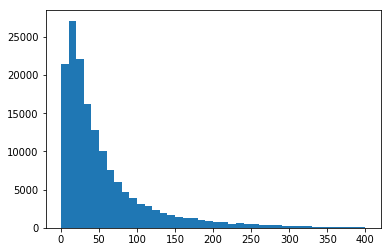

In [20]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


 ## Final Preprocessed Data

In [21]:
train_x[0]



"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [22]:
X_train[0]


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

 ### Stopwords

In [23]:
%load_ext autoreload
%autoreload 2
from utils.preprocessing import filter_stop_words
filtered_train_x = filter_stop_words(train_x)
filtered_test_x = filter_stop_words(test_x)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(filtered_train_x))


In [24]:
tokenized_train_x = tokenizer.texts_to_sequences(filtered_train_x)
tokenized_test_x = tokenizer.texts_to_sequences(filtered_test_x)


In [25]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]



 Total number of words after removing stopwords.

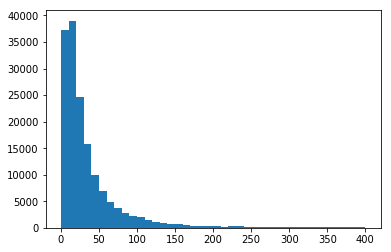

In [26]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


 ### Lemmatization

In [27]:
%autoreload 2
from utils.preprocessing import lemmatize

lemmatized_train_x = lemmatize(filtered_train_x)
lemmatized_test_x = lemmatize(filtered_test_x)

tokenizer.fit_on_texts(list(lemmatized_train_x))


In [28]:
tokenized_train_x = tokenizer.texts_to_sequences(lemmatized_train_x)
tokenized_test_x = tokenizer.texts_to_sequences(lemmatized_test_x)

In [29]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]


 Total number of words after Lemmatization + Stop words correction.

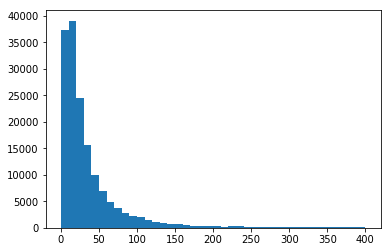

In [30]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


 ### Stemming

In [31]:
%autoreload 2
from utils.preprocessing import stem

stemmed_train_x = stem(filtered_train_x)
stemmed_test_x = stem(filtered_test_x)

tokenizer.fit_on_texts(list(stemmed_train_x))


In [32]:
tokenized_train_x = tokenizer.texts_to_sequences(stemmed_train_x)
tokenized_test_x = tokenizer.texts_to_sequences(stemmed_test_x)

In [33]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]


 Total number of words after Stemming + Stop words correction.

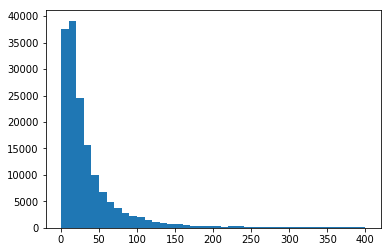

In [34]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


In [35]:
print(train_x[0], "\n")
print(filtered_train_x[0], "\n")
print(lemmatized_train_x[0], "\n")
print(stemmed_train_x[0], "\n")

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 

Explanation Why edits made username Hardcore Metallica Fan reverted? They vandalisms, closure GAs I voted New York Dolls FAC. And please remove template talk page since I'm retired now.89.205.38.27 

Explanation Why edit make username Hardcore Metallica Fan reverted? They vandalisms, closure GAs I vote New York Dolls FAC. And please remove template talk page since I'm retire now.89.205.38.27 

explan whi edit made usernam hardcor metallica fan reverted? they vandalisms, closur ga I vote new york doll fac. and pleas remov templat talk page sinc i'm retir now.89.205.38.27 

